In [1]:
from pathlib import Path
import torch 
from dataclasses import dataclass
import torch.nn.functional as F 

In [2]:
@dataclass
class TensorFile:
    block_idx: int
    sample_idx: int
    token_idx: int 

    MAX_BLOCKS = 12
    DATA_ROOT = Path('./data')

    @property
    def path(self):
        return (
            TensorFile.DATA_ROOT
            .joinpath(f'block{self.block_idx}')
            .joinpath(str(self.sample_idx))
            .joinpath(f'{self.token_idx}.pt')
        )

    def load(self):
        values = torch.load(self.path)
        assert values.shape == (1, 1, 768)
        return values.reshape(-1)

    def next_layer(self):
        if self.block_idx == TensorFile.MAX_BLOCKS - 1:
            return None

        return TensorFile(block_idx=self.block_idx + 1, sample_idx=self.sample_idx, token_idx=self.token_idx) 
    
    def next_token(self):
        ret = TensorFile(block_idx=self.block_idx, sample_idx=self.sample_idx, token_idx=self.token_idx + 1)
        return ret if ret.path.exists() else None 

In [3]:
def load_token(sample_idx: int, token_idx: int):
    cur_file = TensorFile(block_idx=0, sample_idx=sample_idx, token_idx=token_idx)
    tensors = []
    while cur_file is not None:
        tensors.append(cur_file.load().reshape(1, -1))
        cur_file = cur_file.next_layer() 

    return torch.cat(tensors)

In [4]:
token_file = TensorFile(block_idx=0, sample_idx=0, token_idx=0)
lst = []
num_samples = 50
while token_file is not None:
    all_consecutive = []
    for sample_idx in range(num_samples):
        sample = load_token(sample_idx, token_file.token_idx)
        all_consecutive.append(sample.unsqueeze(0))

    all_consecutive = torch.cat(all_consecutive, dim=0)
    lst.append(all_consecutive.unsqueeze(0))
    token_file = token_file.next_token()

lst = torch.cat(lst, dim=0)

FileNotFoundError: [Errno 2] No such file or directory: 'data/block0/27/14.pt'

In [ ]:
lst.shape

torch.Size([9, 50, 12, 768])

In [ ]:
num_layers = TensorFile.MAX_BLOCKS
num_tokens = lst.size(0)
cosine_similarities = torch.zeros(num_tokens, num_samples, 12, 12)
for token_idx in range(num_tokens):
    for sample_idx in range(num_samples):
        for i in range(num_layers):
            for j in range(num_layers):
                cos_sim = None 
                if i == j:
                    cos_sim = torch.tensor([1.0])
                else:
                    cos_sim = F.cosine_similarity(
                        lst[token_idx, sample_idx, i].unsqueeze(0),
                        lst[token_idx, sample_idx, j].unsqueeze(0),
                        dim=1
                    )

                cosine_similarities[token_idx, sample_idx, i, j] = cos_sim

In [ ]:
start = torch.arange(0, num_layers - 1)
consecutive_similarities = cosine_similarities[:, :, start, start + 1]
consecutive_similarities.shape

torch.Size([9, 50, 11])

In [ ]:
consecutive_similarities.view(-1, 11).mean(axis=0)

tensor([0.7525, 0.9384, 0.9537, 0.9699, 0.9550, 0.9476, 0.9525, 0.9504, 0.9298,
        0.9005, 0.9217])

In [ ]:
consecutive_similarities.numel()

4950

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 

<Axes: ylabel='Count'>

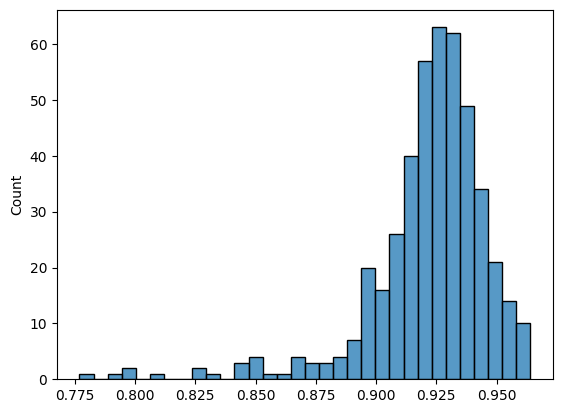

In [ ]:
sns.histplot(consecutive_similarities[:, :, -1].view(-1))

<Axes: ylabel='Count'>

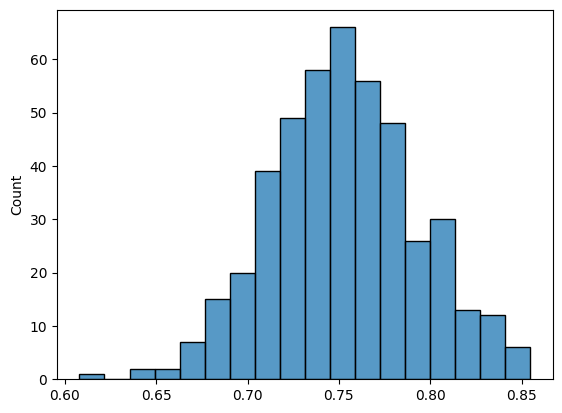

In [ ]:
sns.histplot(consecutive_similarities[:, :, 0].view(-1))

<Axes: ylabel='Count'>

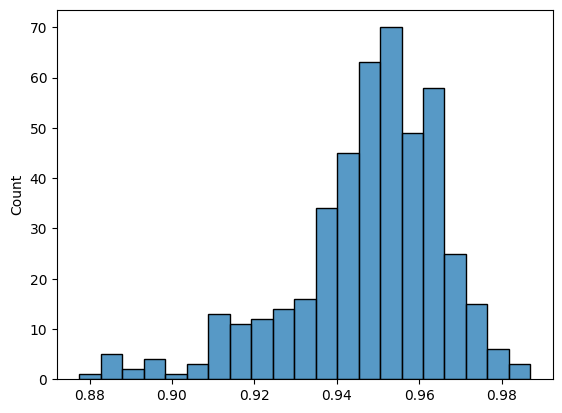

In [ ]:
sns.histplot(consecutive_similarities[:, :, 5].view(-1))

In [ ]:
consecutive_similarities.numel()

4950

In [ ]:
class ConsecDataset:
    '''
    Given in(l) (= out(l - 1)), predict cos(in(l + n), in(l + n + 1)) 
    '''
    def __init__(self, consec_arr: torch.tensor, consec_sims: torch.tensor, n: int):
        # 0 -> n + 1
        # ...
        # num_layers - n - 1 -> num_layers  
        self.num_layers = consec_arr.size(1)
        self.per_sample_len = self.num_layers - n - 1
        self.n = n 
        # assert n >= 1 and n <= num_layers - 1
        # assert n == 1

        self.X = consec_arr
        self.y = consec_sims

        assert self.X.size(0) == self.y.size(0)

    def __len__(self):
        return self.y.size(0) * self.per_sample_len

    def __getitem__(self, idx: int):
        sample_idx = idx // self.per_sample_len
        start_layer_idx = idx % self.per_sample_len
        x = self.X[sample_idx, start_layer_idx]
        # y[s, i] = cos(in(i), in(i + 1))
        y = self.y[sample_idx, start_layer_idx + self.n]
        return x, y

In [ ]:
# (N, 5, 4) tensor
tmp_data = torch.tensor([
    [[1.0, 0.0, 0.0, 0.0],
     [0.0, 1.0, 0.0, 0.0],
     [1.0, 1.0, 0.0, 0.0],
     [0.0, 0.0, 1.0, 0.0],
     [0.0, 0.0, 0.0, 1.0]],

    [[1.0, 2.0, 3.0, 4.0],
     [4.0, 3.0, 2.0, 1.0],
     [1.0, 1.0, 1.0, 1.0],
     [2.0, 2.0, 2.0, 2.0],
     [3.0, 3.0, 3.0, 3.0]]
])
def compute_cosine_similarity(vec1, vec2):
    cos_sim = torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))
    return cos_sim

tmp_sims = torch.zeros((2, 4))
for i in range(2):
    for j in range(4):
        tmp_sims[i, j] = compute_cosine_similarity(tmp_data[i, j], tmp_data[i, j + 1])

dataset = ConsecDataset(tmp_data, tmp_sims, 1)

dataset_idx = 0
for sample_idx in range(tmp_sims.size(0)):
    for start_layer_idx in range(tmp_sims.size(1) - 1):
        x, y = dataset[dataset_idx]
        dataset_idx += 1

        expected_x = tmp_data[sample_idx, start_layer_idx]
        expected_y = tmp_sims[sample_idx, start_layer_idx + 1]

        assert torch.equal(x, expected_x), f"Retrieved x is incorrect at index {sample_idx=}, {start_layer_idx=}"
        assert torch.equal(y, expected_y), f"Retrieved y is incorrect at index {sample_idx=}, {start_layer_idx=}"

        # Calculate cosine similarity by hand
        vec1 = tmp_data[sample_idx, start_layer_idx + 1]
        vec2 = tmp_data[sample_idx, start_layer_idx + 2]
        cos_sim = torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))
        
        assert torch.isclose(y, cos_sim, atol=1e-4), f"Cosine similarity is incorrect at index {sample_idx=}, {start_layer_idx=}: {y} != {cos_sim}"

print("All tests passed!")

All tests passed!


In [ ]:
import torch.nn as nn 

class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
lst.shape, consecutive_similarities.shape

(torch.Size([9, 50, 12, 768]), torch.Size([9, 50, 11]))

In [ ]:
from torch.utils.data import DataLoader
import random 

tmp_data = lst.view(-1, 12, 768)
targets = consecutive_similarities.view(-1, 11) 
N = tmp_data.size(0)
all_indices = list(range(N)) 
random.shuffle(all_indices)
index_bound = int(N * 0.7)
train_data = tmp_data[all_indices[:index_bound]]
train_targets = targets[all_indices[:index_bound]]
test_data = tmp_data[all_indices[index_bound:]]
test_targets = targets[all_indices[index_bound:]]

train_dataset = ConsecDataset(train_data, train_targets, n=1)
test_dataset = ConsecDataset(test_data, test_targets, n=1)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
input_size = train_data.size(-1)
hidden_size = 64
output_size = 1 

model = SimpleMLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device = 'cuda'
model = model.to(device)

In [ ]:
def measure_val_loss(model, val_loader, device):
    epoch_loss = 0
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs).reshape(-1)
        loss = criterion(outputs, labels)

        batch_size = outputs.numel()
        epoch_loss += loss.item() * batch_size / len(val_loader.dataset)

    return epoch_loss

In [ ]:
test_loss = measure_val_loss(model, test_loader, device)
train_loss = measure_val_loss(model, train_loader, device)
train_loss, test_loss

(0.21451749461037767, 0.2156342572856832)

In [ ]:
from tqdm.notebook import tqdm

num_epochs = 10

batch_losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()  
    epoch_loss = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs).reshape(-1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch == 0:
            batch_losses.append(loss.item())
        epoch_loss += loss.item() * batch_size / len(train_data)
    
    if (epoch+1) % 1 == 0:
        val_loss = measure_val_loss(model, test_loader, device)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4e}, Val Loss: {val_loss:.4e}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 2.4854e-01, Val Loss: 4.1487e-03
Epoch [2/10], Loss: 2.9986e-02, Val Loss: 2.5503e-03
Epoch [3/10], Loss: 1.7572e-02, Val Loss: 1.3926e-03
Epoch [4/10], Loss: 8.6818e-03, Val Loss: 7.7578e-04
Epoch [5/10], Loss: 5.6167e-03, Val Loss: 6.7387e-04
Epoch [6/10], Loss: 4.4995e-03, Val Loss: 6.1232e-04
Epoch [7/10], Loss: 3.8912e-03, Val Loss: 5.5792e-04
Epoch [8/10], Loss: 3.5391e-03, Val Loss: 5.6759e-04
Epoch [9/10], Loss: 3.2551e-03, Val Loss: 6.2569e-04
Epoch [10/10], Loss: 3.0488e-03, Val Loss: 6.5738e-04


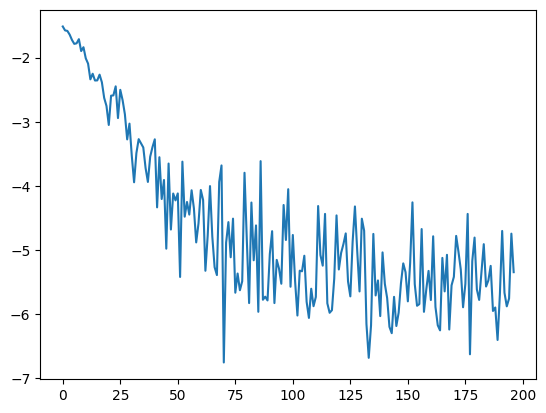

In [ ]:
import numpy as np

plt.plot(list(range(len(batch_losses))), np.log(np.array(batch_losses)))

In [ ]:
test_loss = measure_val_loss(model, test_loader, device)
train_loss = measure_val_loss(model, train_loader, device)
train_loss, test_loss

(0.0002833828894192324, 0.0006573836903812156)

In [ ]:
lst.shape

torch.Size([9, 50, 12, 768])

In [ ]:
x = lst[0, 0, 0].to(device)
%timeit model(x)

85.5 µs ± 5.54 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
train_data.shape, test_data.shape

(torch.Size([315, 12, 768]), torch.Size([135, 12, 768]))

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

X_list = []
y_list = []

for i in tqdm(range(len(train_dataset))):
    x, y = train_dataset[i]
    X_list.append(x.cpu().detach().numpy())
    y_list.append(y.cpu().detach().numpy())

X = np.array(X_list)
y = np.array(y_list).reshape(-1, 1)

# Train a linear regression model using sklearn
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

mse_loss = mean_squared_error(y, y_pred)
print(f'Training Loss (MSE): {mse_loss:.4e}')

  0%|          | 0/3150 [00:00<?, ?it/s]

Training Loss (MSE): 2.0408e-04


In [ ]:
X_list = []
y_list = []

for i in tqdm(range(len(test_dataset))):
    x, y = test_dataset[i]
    X_list.append(x.cpu().detach().numpy())
    y_list.append(y.cpu().detach().numpy())

X = np.array(X_list)
y = np.array(y_list).reshape(-1, 1)
y_pred = model.predict(X)
print(f'Test MSE:{mean_squared_error(y, y_pred):.4e}')

  0%|          | 0/1350 [00:00<?, ?it/s]

Test MSE:9.6672e-04
